In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import csv

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

graph_type = nx.Graph()

nodes = pd.read_csv('Documentation/nodes.csv', header=None)
nodes.columns = ["Node ID", "x_coordinate", "y_coordinate"]
nodescoordinates = nodes.iloc[:,1:]
nodesid = nodes.iloc[:,0]

links = pd.read_csv('Documentation/links.csv', header=None)
links.columns = ["Link ID", "Lenght", "Number of lanes", "Starting node ID", "Ending node ID", "Region"]

couple = pd.Series

#G = nx.from_pandas_edgelist(nodesid, source='x_coordinate', target='y_coordinate', create_using=graph_type)

G = nx.Graph()

G.add_nodes_from(nodes["Node ID"])
# G.add_edges_from(links[])

axes = plt.axes()

nx.draw(G, ax = axes)

# printgraph()

# print("test")


ValueError: Length mismatch: Expected axis has 6 elements, new values have 7 elements

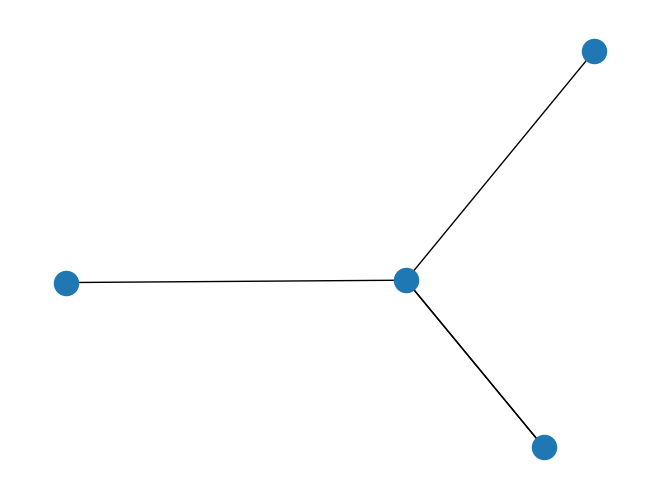

In [13]:
edges = pd.DataFrame(
    {
        "source": [0, 1, 2, 0],
        "target": [2, 2, 3, 2],
        "my_edge_key": ["A", "B", "C", "D"],
        "weight": [3, 4, 5, 6],
        "color": ["red", "blue", "blue", "blue"],
    }
)
G = nx.from_pandas_edgelist(
    edges,
    edge_key="my_edge_key",
    edge_attr=["weight", "color"],
    create_using=nx.MultiGraph(),
)
G[0][2]

nx.draw(G)
plt.show()